In [2]:
%load_ext autoreload
%autoreload 2

In [2]:
from globalVariables import *
import simpleCNNwithInception as inceptionCNN
import simpleCNN as simpleCNN
import simpleCNNwithInceptionRegression as regressor
from keras.callbacks import CSVLogger
from scipy.ndimage import rotate
from tools import plot_confusion_matrix
from getSIDMdata_generator import get_tf_DataSet as getGenerators
import scienceplots
plt.style.use(["science", "grid"])

In [4]:
from tensorflow.keras.applications import resnet

In [6]:
def setup_resnet_wrapper( inputShape, resnet):
    
    inputLayer = Input(shape=inputShape)
    model = resnet(inputLayer)
    model = tf.keras.layers.Flatten( )( model )
    model = layers.Dense(128, activation='relu')( model )
    model = tf.keras.layers.Dense(4)(model)
    finalModel = Model(inputLayer, model)
    finalModel.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
    
    return finalModel

#### Fiducial

In [5]:
simulationNames = ['CDM','SIDM0.1','SIDM1']
nClasses = len(simulationNames)
epochs=80

In [ ]:
fiducial_train_ds, fiducial_test_ds  = getGenerators(augment_data=True, simulationNames=simulationNames, channels=['total','stellar','xray'], 
                                                      allDataFile='pickles/binned_data_20.pkl')
all_channels = simpleCNN.getModel_ds(nClasses)
history = all_channels.fit(
  x=fiducial_train_ds,
  validation_data=fiducial_test_ds,
  epochs=epochs
)

In [3]:
#Mertens architectures :
inception, bipare = pkl.load(open("../mydnn/architecture_test.pkl","rb"))

In [8]:
pkl.dump([all_channels.history.history, inception, bipare], open("pickles/test_arch.pkl","wb"))

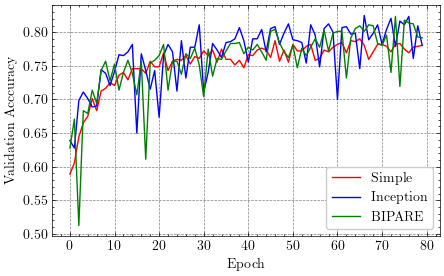

In [10]:
plt.figure(figsize=(5,3))
plt.xlabel('Epoch')
plt.ylabel('Validation Acccuracy')

c = ['r','b','g','c','y','k']
name=['Simple','Inception','BIPARE']
models = pkl.load(open("pickles/test_arch.pkl","rb"))


for i, iModel in enumerate(models):
    plt.plot(np.arange(len(iModel['val_accuracy'])), iModel['val_accuracy'], label=name[i], c=c[i])
    #plt.plot(iModel.history.epoch, [np.max(iModel.history.history['val_accuracy'])]*len(iModel.history.epoch), c=c[i])
    #print(np.max(iModel.history.history['val_accuracy']))

plt.legend()
plt.savefig("../plots/architecture_test.pdf")

## Various resenets that dont really work since the interpolation to larger images fucks things

#### 1. Resnet 50

In [12]:
inputShape = train_a[0][0].shape[1:]
resnet_50 = resnet.ResNet50( classes=4, weights=None, include_top=False, pooling='max', input_shape=inputShape)
resenet_50_model = setup_resnet_wrapper( inputShape, resnet_50 )

In [13]:
resnet_50_history = resenet_50_model.fit(
      x=train_a,
        validation_data=test_a,
      epochs=epochs, verbose=1 )

Epoch 1/80
90/90 [==============================] - 307s 3s/step - loss: 2.6947 - accuracy: 0.5292 - val_loss: 1.0069 - val_accuracy: 0.4875
Epoch 2/80
90/90 [==============================] - 285s 3s/step - loss: 0.7839 - accuracy: 0.6229 - val_loss: 0.8614 - val_accuracy: 0.5972
Epoch 3/80
90/90 [==============================] - 236s 3s/step - loss: 0.6948 - accuracy: 0.6517 - val_loss: 0.7609 - val_accuracy: 0.6528
Epoch 4/80
90/90 [==============================] - 235s 3s/step - loss: 0.6720 - accuracy: 0.6726 - val_loss: 0.8529 - val_accuracy: 0.6000
Epoch 5/80
90/90 [==============================] - 236s 3s/step - loss: 0.6425 - accuracy: 0.6788 - val_loss: 1.1101 - val_accuracy: 0.5181
Epoch 6/80
90/90 [==============================] - 236s 3s/step - loss: 0.6318 - accuracy: 0.6969 - val_loss: 1.3478 - val_accuracy: 0.5250
Epoch 7/80
90/90 [==============================] - 243s 3s/step - loss: 0.6171 - accuracy: 0.6948 - val_loss: 1.3943 - val_accuracy: 0.4722
Epoch 8/80
90

KeyboardInterrupt: 

#### 2. Resnet 50 v2

In [27]:
from tensorflow.keras.applications import resnet_v2

In [32]:
inputShape = train_a[0][0].shape[1:]
resnet_50_v2= resnet_v2.ResNet50V2( classes=4, weights=None, include_top=False, pooling='max', input_shape=inputShape, classifier_activation=None)
resnet_50_v2_model = setup_resnet_wrapper( inputShape, resnet_50_v2 )

In [ ]:
epochs=20
au_history = resnet_50_v2_model.fit(
      x=train_a,
        validation_data=test_a,
      epochs=epochs, verbose=1 )

#### 2. Resnet 50 v2 with imagenet weights

In [50]:
inputShape = train_a[0][0].shape[1:] = dataset_to_numpy[0][0].shape[1:]

In [53]:
resnet_50_v2= resnet_v2.ResNet50V2( pooling='max' )

In [59]:

# add a global spatial average pooling layer
x = resnet_50_v2.output
# let's add a fully-connected layer
x = tf.keras.layers.Dense(1024, activation='relu')(x)
# and a logistic layer -- let's say we have 200 classes
predictions = tf.keras.layers.Dense(4)(x)

# this is the model we will train
model = Model(inputs=resnet_50_v2.input, outputs=predictions)

# first: train only the top layers (which were randomly initialized)
# i.e. freeze all convolutional InceptionV3 layers
for layer in resnet_50_v2.layers:
    layer.trainable = False
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [60]:
au_history = model.fit(
      x=train_a,
        validation_data=test_a,
      epochs=epochs, verbose=1 )

Epoch 1/20
120/120 [==============================] - 166s 1s/step - loss: 1.3551 - accuracy: 0.3216 - val_loss: 1.3152 - val_accuracy: 0.3587
Epoch 2/20
120/120 [==============================] - 162s 1s/step - loss: 1.3346 - accuracy: 0.3414 - val_loss: 1.3042 - val_accuracy: 0.3452
Epoch 3/20
120/120 [==============================] - 163s 1s/step - loss: 1.3366 - accuracy: 0.3305 - val_loss: 1.3056 - val_accuracy: 0.3034
Epoch 4/20
120/120 [==============================] - 162s 1s/step - loss: 1.3257 - accuracy: 0.3383 - val_loss: 1.3058 - val_accuracy: 0.3003
Epoch 5/20
120/120 [==============================] - 162s 1s/step - loss: 1.3248 - accuracy: 0.3406 - val_loss: 1.3042 - val_accuracy: 0.3003
Epoch 6/20
120/120 [==============================] - 161s 1s/step - loss: 1.3227 - accuracy: 0.3341 - val_loss: 1.3015 - val_accuracy: 0.3003
Epoch 7/20
120/120 [==============================] - 163s 1s/step - loss: 1.3208 - accuracy: 0.3401 - val_loss: 1.2976 - val_accuracy: 0.3420